<a href="https://colab.research.google.com/github/Josh0527/Fraud-Detection-Model/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub
import os

#Download latest version
path = kagglehub.dataset_download("samayashar/fraud-detection-transactions-dataset")
print("Path to dataset files:", path)

#check url for file name
os.listdir(path)

100%|██████████| 2.01M/2.01M [00:00<00:00, 41.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/samayashar/fraud-detection-transactions-dataset/versions/1


['synthetic_fraud_dataset.csv']

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE

In [3]:
#import file

df = pd.read_csv(path + "/synthetic_fraud_dataset.csv")
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


# Data Exploration & Prep


In [4]:
#get data info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

In [5]:
#Summary Statistics

display('Summary Statistics:', df.describe())

'Summary Statistics:'

,Transaction_Amount,Account_Balance,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Age,Transaction_Distance,Risk_Score,Is_Weekend,Fraud_Label
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,99.411012,50294.065981,0.05020,0.098400,7.485240,255.271924,2.003540,119.999940,2499.164155,0.501556,0.299640,0.321340
std,98.687292,28760.458557,0.21836,0.297858,4.039637,141.382279,1.414273,68.985817,1442.013834,0.287774,0.458105,0.466996
min,0.000000,500.480000,0.00000,0.000000,1.000000,10.000000,0.000000,1.000000,0.250000,0.000100,0.000000,0.000000
25%,28.677500,25355.995000,0.00000,0.000000,4.000000,132.087500,1.000000,60.000000,1256.497500,0.254000,0.000000,0.000000
50%,69.660000,50384.430000,0.00000,0.000000,7.000000,256.085000,2.000000,120.000000,2490.785000,0.502250,0.000000,0.000000
75%,138.852500,75115.135000,0.00000,0.000000,11.000000,378.032500,3.000000,180.000000,3746.395000,0.749525,1.000000,1.000000
max,1174.140000,99998.310000,1.00000,1.000000,14.000000,500.000000,4.000000,239.000000,4999.930000,1.000000,1.000000,1.000000


In [8]:
#iterates and return selected categroical column unique values as list

col_list = ['Is_Weekend','Merchant_Category', 'Device_Type', 'Location', 'Card_Type' ]

for i in col_list:
    print(i, df[i].unique())
    print('-' * 20)

Is_Weekend [0 1]
--------------------
Merchant_Category ['Travel' 'Clothing' 'Restaurants' 'Electronics' 'Groceries']
--------------------
Device_Type ['Laptop' 'Mobile' 'Tablet']
--------------------
Location ['Sydney' 'New York' 'Mumbai' 'Tokyo' 'London']
--------------------
Card_Type ['Amex' 'Mastercard' 'Visa' 'Discover']
--------------------


In [ ]:
# Compare IP_Address_Flag and Fraud_Label
comparison_df = pd.crosstab(df['IP_Address_Flag'], df['Fraud_Label'])

print("Comparison Table:\n", comparison_df)

# Calculate correlation to measure strength of relationship
correlation = df[['IP_Address_Flag', 'Fraud_Label']].corr().iloc[0, 1]
print(f"\nCorrelation between IP_Address_Flag and Fraud_Label: {correlation:.2f}")

Comparison Table:
 Fraud_Label          0      1
IP_Address_Flag              
0                32245  15245
1                 1688    822

Correlation between IP_Address_Flag and Fraud_Label: 0.00


Correlation with Fraud_Label:
 Account_Balance    -0.003153
Location_Encoded    0.004680
Name: Fraud_Label, dtype: float64


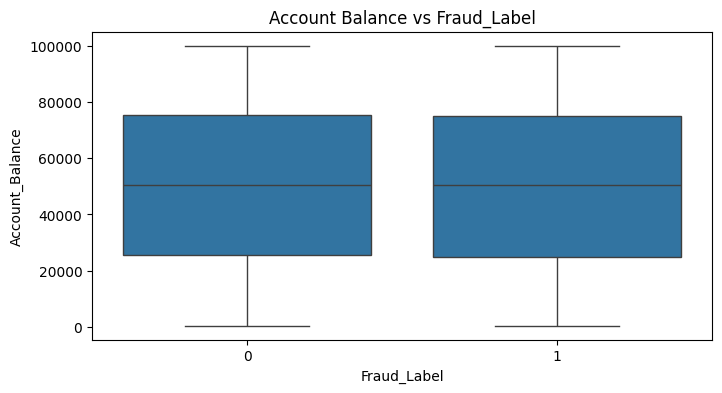

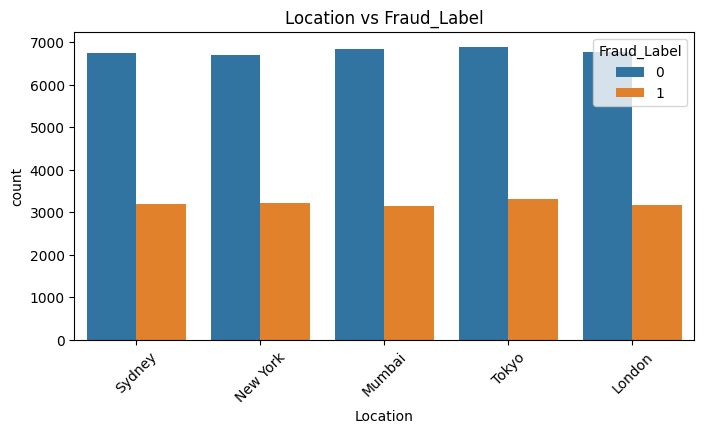

In [ ]:
#temporary encoding for correlation check
temp_df = df.copy()
temp_df['Location_Encoded'] = LabelEncoder().fit_transform(temp_df['Location'])

#correlation check
correlation = temp_df[['Account_Balance', 'Location_Encoded', 'Fraud_Label']].corr()['Fraud_Label'].drop('Fraud_Label')

print("Correlation with Fraud_Label:\n", correlation)

#Visualizing
#account Balance vs Fraud_Label

plt.figure(figsize=(8, 4))
sns.boxplot(x='Fraud_Label', y='Account_Balance', data=df)
plt.title('Account Balance vs Fraud_Label')
plt.show()

#location Analysis (Categorical)

plt.figure(figsize=(8, 4))
sns.countplot(x='Location', hue='Fraud_Label', data=df)
plt.title('Location vs Fraud_Label')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#drop irrelevant columns

cols_to_drop = ['Transaction_ID', 'User_ID', 'Timestamp', 'Location']
df.drop(cols_to_drop, axis=1, inplace=True)

print("Remaining columns:", df.columns)

Remaining columns: Index(['Transaction_Amount', 'Transaction_Type', 'Account_Balance',
       'Device_Type', 'Merchant_Category', 'IP_Address_Flag',
       'Previous_Fraudulent_Activity', 'Daily_Transaction_Count',
       'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Type',
       'Card_Age', 'Transaction_Distance', 'Authentication_Method',
       'Risk_Score', 'Is_Weekend', 'Fraud_Label'],
      dtype='object')


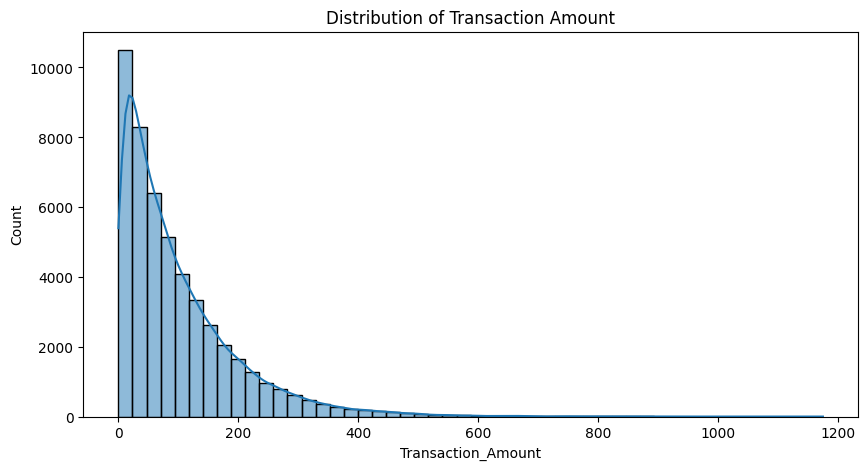

In [ ]:
#distribution Analysis of transaction_amount

plt.figure(figsize=(10, 5))
sns.histplot(df['Transaction_Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amount')
plt.show()

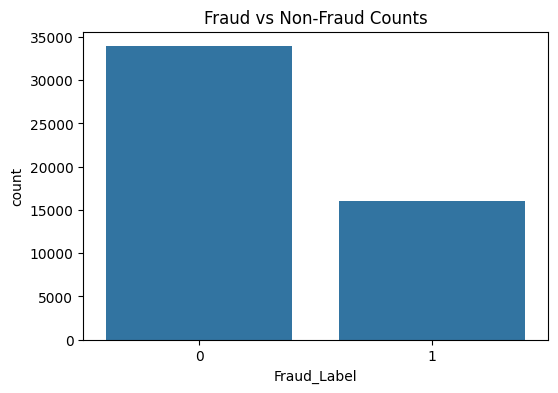

In [ ]:
#Target Variable Analysis (fraud comparison)

plt.figure(figsize=(6, 4))
sns.countplot(x='Fraud_Label', data=df)
plt.title('Fraud vs Non-Fraud Counts')
plt.show()

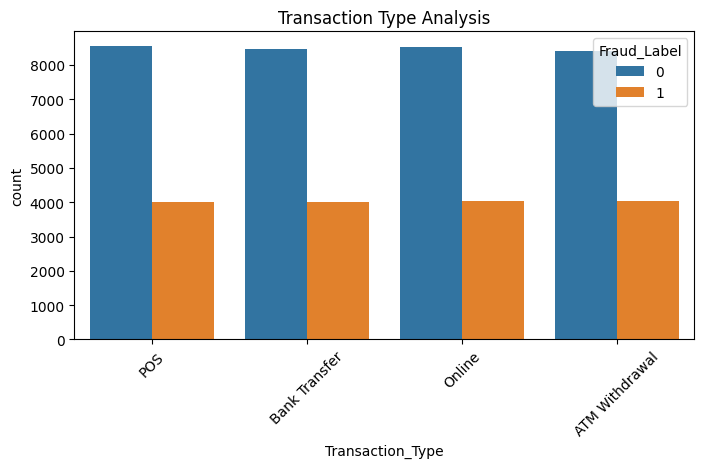

In [ ]:
#transaction_type Feature Analysis

plt.figure(figsize=(8, 4))
sns.countplot(x='Transaction_Type', hue='Fraud_Label', data=df)
plt.title('Transaction Type Analysis')
plt.xticks(rotation=45)
plt.show()

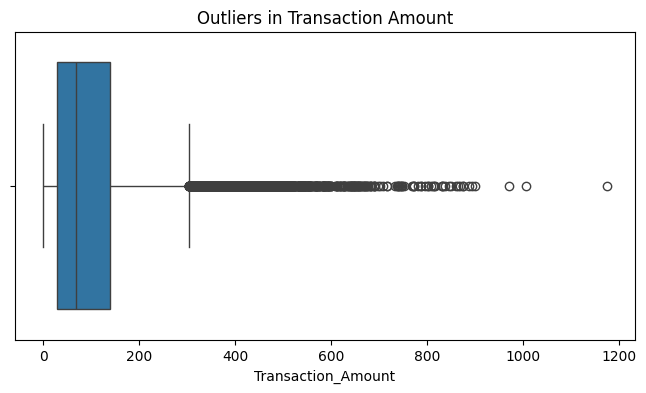

In [ ]:
#possible outlier check

plt.figure(figsize=(8, 4))
sns.boxplot(x='Transaction_Amount', data=df)
plt.title('Outliers in Transaction Amount')
plt.show()

# Feature Engineering


In [ ]:
#create IP_Mismatch feature
df['IP_Mismatch'] = ((df['IP_Address_Flag'] == 1) &
                     (df['Previous_Fraudulent_Activity'] == 0)).astype(int)

# Verify the new column
print(df['IP_Mismatch'].value_counts())

IP_Mismatch
0    47710
1     2290
Name: count, dtype: int64


In [ ]:
#High-Value Transaction Flag
df['High_Value_Transaction'] = (df['Transaction_Amount'] > 500).astype(int)

#Frequent Transaction Indicator
df['Frequent_Transaction'] = (df['Daily_Transaction_Count'] > 10).astype(int)

#Risk Score Bins
df['Risk_Score_Category'] = pd.cut(df['Risk_Score'],
                                   bins=[0, 0.3, 0.7, 1],
                                   labels=['Low', 'Medium', 'High'])

#check new features
print(df[['High_Value_Transaction', 'Frequent_Transaction', 'Risk_Score_Category']].head())

   High_Value_Transaction  Frequent_Transaction Risk_Score_Category
0                       0                     0                High
1                       0                     1                 Low
2                       0                     1                High
3                       0                     0                High
4                       0                     1              Medium


In [ ]:
#Calculate Expected Spend
df['Expected_Spend'] = df['Account_Balance'] / df['Daily_Transaction_Count']

#create a flag for unexpected high spending
df['Unexpected_Spend'] = (df['Transaction_Amount'] > 2 * df['Expected_Spend']).astype(int)

# Check features
print(df['Unexpected_Spend'].value_counts())


Unexpected_Spend
0    49930
1       70
Name: count, dtype: int64


In [ ]:
#Refine High-Value Transaction Feature
df['High_Value_Transaction'] = (
    (df['Unexpected_Spend'] == 1) | (df['Transaction_Amount'] > 500)
).astype(int)

#confirm updated feature
print(df['High_Value_Transaction'].value_counts())

High_Value_Transaction
0    49642
1      358
Name: count, dtype: int64


In [ ]:
#drop redundant columns
df.drop(['IP_Address_Flag', 'Previous_Fraudulent_Activity', 'Risk_Score_Category', 'Device_Type'], axis=1, inplace=True)
df.head(2)

,Transaction_Amount,Transaction_Type,Account_Balance,Merchant_Category,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label,IP_Mismatch,High_Value_Transaction,Frequent_Transaction,Expected_Spend,Unexpected_Spend
0,39.79,POS,93213.17,Travel,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0,0,0,0,13316.167143,0
1,1.19,Bank Transfer,75725.25,Clothing,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1,0,0,1,5825.019231,0


In [ ]:
# One-Hot Encoding for 'Authentication_Method' & 'Transaction_Type'
df = pd.get_dummies(df, columns=['Authentication_Method', 'Transaction_Type', 'Merchant_Category', 'Card_Type'], drop_first=True)

# Convert all boolean columns to integers
for col in df.select_dtypes('bool').columns:
    df[col] = df[col].astype(int)

# Display updated DataFrame
display(df.head(2))

,Transaction_Amount,Account_Balance,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Age,Transaction_Distance,Risk_Score,Is_Weekend,Fraud_Label,...,Transaction_Type_Bank Transfer,Transaction_Type_Online,Transaction_Type_POS,Merchant_Category_Electronics,Merchant_Category_Groceries,Merchant_Category_Restaurants,Merchant_Category_Travel,Card_Type_Discover,Card_Type_Mastercard,Card_Type_Visa
0,39.79,93213.17,7,437.63,3,65,883.17,0.8494,0,0,...,0,0,1,0,0,0,1,0,0,0
1,1.19,75725.25,13,478.76,4,186,2203.36,0.0959,0,1,...,1,0,0,0,0,0,0,0,1,0


# ML Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

In [ ]:
#split data

X = df.drop('Fraud_Label', axis=1)
y = df['Fraud_Label']

X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Fraud_Label', axis=1), df['Fraud_Label'], test_size=0.2, random_state=42
)

In [ ]:
len(X_train), len(X_test)

(40000, 10000)

In [ ]:
#model trianing

model = RandomForestClassifier(class_weight='balanced' ,random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
#predict

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # For threshold tuning
# Tune threshold for better balance
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
optimal_idx = np.argmax(2 * precision * recall / (precision + recall))  # Maximizing F1 Score
optimal_threshold = thresholds[optimal_idx]

# Final predictions using tuned threshold
y_final_pred = (y_prob >= optimal_threshold).astype(int)

# Evaluation
print(classification_report(y_test, y_final_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6765
           1       1.00      1.00      1.00      3235

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

ROC-AUC Score: 1.0000


## Re-train (Handling Class Imnbalance & Overfitting)

In [ ]:
#retrained using temp_df to avoid alteration on our main df
#feature engineering (transformations)
#binning Risk_Score

#create copy
temp_df = df.copy()

temp_df['Risk_Score_Binned'] = pd.qcut(temp_df['Risk_Score'], q=4, labels=[1, 2, 3, 4])

#capping Failed_Transaction_Count_7d
temp_df['Failed_Transaction_Capped'] = temp_df['Failed_Transaction_Count_7d'].clip(upper=temp_df['Failed_Transaction_Count_7d'].quantile(0.95))

In [ ]:
#drop original dominant features
temp_df.drop(['Risk_Score', 'Failed_Transaction_Count_7d'], axis=1, inplace=True)

#split
X = temp_df.drop('Fraud_Label', axis=1)
y = temp_df['Fraud_Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#handling class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
#train model
model_f = RandomForestClassifier(random_state=42)
model_f.fit(X_train_resampled, y_train_resampled)

#evaluate
y_pred = model_f.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred):.4f}")

              precision    recall  f1-score   support

           0       0.98      0.89      0.94     10138
           1       0.81      0.97      0.88      4862

    accuracy                           0.92     15000
   macro avg       0.90      0.93      0.91     15000
weighted avg       0.93      0.92      0.92     15000

ROC-AUC Score: 0.9299


In [ ]:
#save model
import joblib
joblib.dump(model_f, 'fraud_detect_model.pkl')

['fraud_detect_model.pkl']